# Homework 4

## Importing Data and Setting up Notebook

Here I am just importing the data and importing all of the special code that we will use in this notebook.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from tpot import TPOTClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn import feature_selection
%matplotlib inline

train=pd.read_csv("C:\\Users\Mason\Documents\School\Winter 2019\Econ 213R\costa_rican_household_poverty_prediction\Train.csv")
test=pd.read_csv("C:\\Users\Mason\Documents\School\Winter 2019\Econ 213R\costa_rican_household_poverty_prediction\Test.csv")

C:\Users\Mason\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\Mason\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


I am preparing my target variable and am droping the Id and Target columns from my data. 

In [2]:
train_df=train.drop(['Target', 'Id'], axis=1)
test_df=test.drop(['Id'], axis=1)

I am getting a look at the target data to see what we are working with. It is important to note that the target classifications are not evenly distributed. We will do some things to help deal with this in our later models. As such though, accuracy alone will not be a great measure for our models. 

Text(0.5,1,'Household Poverty Levels')

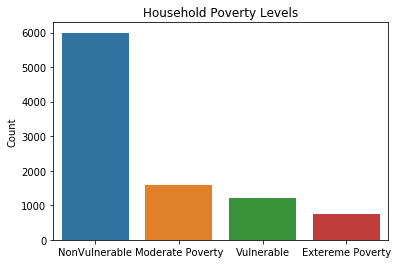

In [3]:
target = train['Target'].value_counts().to_frame()
levels = ["NonVulnerable", "Moderate Poverty", "Vulnerable", "Extereme Poverty"]
trace = sns.barplot(y=target.Target, x=levels)
plt.ylabel('Count')
plt.title('Household Poverty Levels')


## Data Cleaning

Most of the data cleaning for this dataset came down to dealing with missing variables. lucky for us there are only five features with missing data and of those five have virtually no missing data at all. Here I plot the percentage of data missing from each of the features for both the test and train set. 

In [4]:
train_df_na=(train_df.isnull().sum()/len(train_df))*100
train_df_na=train_df_na.drop(train_df_na[train_df_na == 0].index).sort_values(ascending=False)[:30]
test_df_na=(test_df.isnull().sum()/len(test_df))*100
test_df_na=test_df_na.drop(test_df_na[test_df_na == 0].index).sort_values(ascending=False)[:30]

Text(0.5,1,'Missing Variables in Train Set')

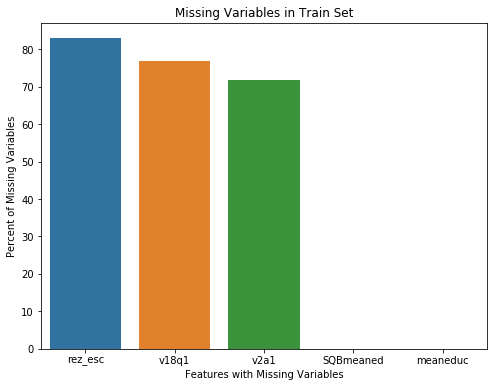

In [5]:
fig, ax =plt.subplots(figsize=(8,6))
sns.barplot(x=train_df_na.index, y= train_df_na)

plt.xlabel('Features with Missing Variables')
plt.ylabel('Percent of Missing Variables')
plt.title('Missing Variables in Train Set')

Text(0.5,1,'Missing Variables in Test Set')

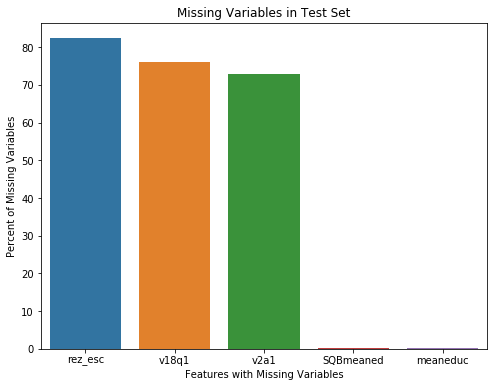

In [6]:
fig, ax =plt.subplots(figsize=(8,6))
sns.barplot(x=test_df_na.index, y=test_df_na)
plt.xlabel('Features with Missing Variables')
plt.ylabel('Percent of Missing Variables')
plt.title('Missing Variables in Test Set')

From the data information on Kaggle we can look up what these variables mean

rez_esc=years behind in school

v18q1= number of tablets household owns

v2a1= Monthly rent payment

SQBmeaned= square of the mean years of education of 

meaneduc=average years of education for adults (18+)

I am trying to get a sense for how these variables are distributed to see how to best deal with these missing values. For years behind in school I think that if it is not reported it is most likely due to the fact that if you are not in school then you would not be any years behind in school. Also, if the number of tablets a household owns is not reported it is safe to assume that there are none. I guess this may not be the safest assumption given I don't know much about how the data was gathered but looking at our distribution and looking through the data it seems good enough. These two variables I set all missing data equal to zero. I also set v2a1's missing data equal to zero because I saw pointed out on a kaggle kernal that if someone pays off their house then they would no longer be reporting a rent payment. For the last two, the amount of missing in the data was so small that I just filled in missing data with an average using the interpolate function. 

In [7]:

print(train.rez_esc.describe())
print(train.v18q1.describe())
print(train.v2a1.describe())
print(train.SQBmeaned.describe())
print(train.meaneduc.describe())

count    1629.000000
mean        0.459791
std         0.946550
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: rez_esc, dtype: float64
count    2215.000000
mean        1.404063
std         0.763131
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: v18q1, dtype: float64
count    2.697000e+03
mean     1.652316e+05
std      1.504571e+05
min      0.000000e+00
25%      8.000000e+04
50%      1.300000e+05
75%      2.000000e+05
max      2.353477e+06
Name: v2a1, dtype: float64
count    9552.000000
mean      102.588867
std        93.516890
min         0.000000
25%        36.000000
50%        81.000000
75%       134.560010
max      1369.000000
Name: SQBmeaned, dtype: float64
count    9552.000000
mean        9.231523
std         4.167694
min         0.000000
25%         6.000000
50%         9.000000
75%        11.600000
max        37.000000
Name: meaneduc, dtype: float64


In [8]:
train_df.v18q1=train_df.v18q1.fillna(0)

test_df.v18q1=test_df.v18q1.fillna(0)


train_df.v2a1=train_df.v2a1.fillna(0)
test_df.v2a1=test_df.v2a1.fillna(0)

train_df.loc[((train_df['age'] >= 18) | (train_df['age'] < 7)) & (train_df['rez_esc'].isnull()), 'rez_esc'] = 0
test_df.loc[((test_df['age'] >= 18) | (test_df['age'] < 7)) & (test_df['rez_esc'].isnull()), 'rez_esc'] = 0

train_df['rez_esc'] = train_df.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))
test_df['rez_esc'] = test_df.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))
train_df['SQBmeaned'] = train_df['SQBmeaned'].transform(lambda x: x.fillna(x.median()))
test_df['SQBmeaned'] = test_df['SQBmeaned'].transform(lambda x: x.fillna(x.median()))
train_df['meaneduc'] = train_df['meaneduc'].transform(lambda x: x.fillna(x.median()))
test_df['meaneduc'] = train_df['meaneduc'].transform(lambda x: x.fillna(x.median()))

train_clean=train_df
test_clean=test_df

I am now going to move on to work with cleaning up the columns that are objects. We cannot run our models until we take care of these. Below I see that there are 4 object columns that need our attention. 

In [9]:
print(train_clean.info())
print(test_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 141 entries, v2a1 to agesq
dtypes: float64(8), int64(129), object(4)
memory usage: 10.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 141 entries, v2a1 to agesq
dtypes: float64(8), int64(129), object(4)
memory usage: 25.7+ MB
None


We see that the objects are mostly columns that have some yes and no's in them so we will convert them to their binary counterparts. Some discussions on kaggle led me to choose to convert 'yes' to 1 and 'no' to 0. 

In [10]:
print(test_clean.select_dtypes(include = [object]).head())
train_clean.select_dtypes(include = [object]).head()

     idhogar dependency edjefe edjefa
0  72958b30c         .5     no     17
1  72958b30c         .5     no     17
2  72958b30c         .5     no     17
3  5b598fbc9         no     16     no
4  1e2fc704e          8     no     11


,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


In [11]:
mapping= {"yes":1, "no":0}
for df in [train_clean, test_clean]:
    df['dependency']=df['dependency'].replace(mapping).astype(np.float)
    df['edjefa']=df['edjefa'].replace(mapping).astype(np.int)
    df['edjefe']=df['edjefe'].replace(mapping).astype(np.int)
    
train_clean[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


Text(0.5,1,'Distribution of Target')

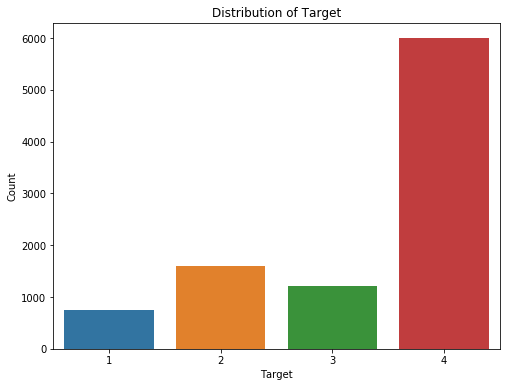

In [12]:
fig, ax =plt.subplots(figsize=(8,6))
sns.countplot(train.Target)
plt.ylabel('Count')
plt.title('Distribution of Target')

Here I drop the last Categorical variable which is an id for family. In the competition they rate you on family level prediction but the data is person level so that Id is meant to allow you to make family level observations. Since we did not submit this to kaggle though I have just kept it at person level and drop this second identification column. 

In [13]:

Train= train_clean.drop('idhogar', axis = 1)
Test= test_clean.drop('idhogar', axis = 1)

In [14]:
print(Train.select_dtypes(include=['object']).head(10))
print(Test.select_dtypes(include=['object']).head(10))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Since the dataset already contains several variables that have been squared and averaged and some that are ratios of things I have decided not to add any more features to the model. On some initial models I've run I have had some serious overfitting and so I think we will get complex enough models with the features we already have. 

## Building Models

I plan on running through a number of models and seeing which ones work best after some hypertuning. But first here I am looking at the correlation between the target and the features. As we would expect mean education of adults in the household and whether or not the home has a roof are at the top of the list as well as overcrowding is near the bottom with a high negative score. 

In [15]:
corr=train.corr()
corr.sort_values(["Target"], ascending=False, inplace=True)
print(corr.Target)


Target             1.000000
meaneduc           0.335203
cielorazo          0.304421
escolari           0.302305
SQBescolari        0.296577
eviv3              0.294222
epared3            0.292451
pisomoscer         0.280284
SQBmeaned          0.276620
v2a1               0.273559
paredblolad        0.261274
etecho3            0.257378
SQBedjefe          0.246368
v18q               0.238864
rooms              0.226208
instlevel8         0.214351
qmobilephone       0.199707
computer           0.183113
lugar1             0.173359
bedrooms           0.166943
hogar_adul         0.160133
elimbasu1          0.160051
television         0.157065
energcocinar2      0.156457
tipovivi2          0.143891
estadocivil3       0.129730
refrig             0.126792
age                0.117620
mobilephone        0.106421
r4h2               0.101253
                     ...   
estadocivil1      -0.135651
hacapo            -0.138008
etecho2           -0.139205
elimbasu3         -0.140924
SQBhogar_total    -0

I played with different sizes for the heatmap and found this was the best. Worry less about the numbers and more about the colors when evaluating the correlation between variables. 

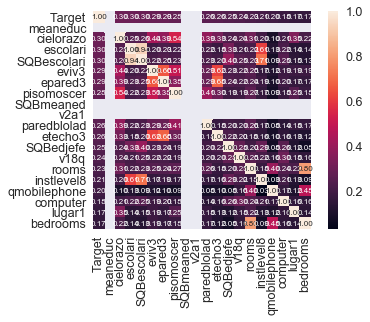

In [17]:
k=20
cor=corr.nlargest(k, "Target")['Target'].index
cm=np.corrcoef(train[cor].values.T)
sns.set(font_scale=1.25)
heat=sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cor.values, xticklabels=cor.values)



Here I am scaling the data and setting up my test/train split.

In [18]:
scaler=StandardScaler(10)

scaler.fit(Train)
scaled_df=scaler.transform(Train)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, train.Target, test_size=0.33, random_state=42)

I run through four models below: Random Forrest, SVC, Gradient Boosting, and KNearest Neighbors. I printed out the long cv_results because it lets me see exactly where my train and test scores begin to deviate signaling that the model is starting to overfit the data. Also, the SVC model does a poor job at predicting some classes so it throws an error when trying to average the f1_macro score. By printing out the longer results I am able to get a more accurate look at what the f1_macro scores truly are. I also print out the recall, precision, and accuracy scores for each model.  

In [20]:
param_dictionary= {"n_estimators":[1000, 2000, 5000], "max_depth":[1 ,3 ,5 ,10]}
score=['f1_macro', 'accuracy']
clf=RandomForestClassifier(n_jobs=-1, n_estimators=10, max_depth=5)
gs=GridSearchCV(clf, param_dictionary, scoring=score, n_jobs=-1, cv=5, return_train_score=True, refit='f1_macro')
gs.fit(X_train, y_train)
print()

In [21]:
y_pred_train= gs.predict(X_train)
y_pred_test = gs.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

             precision    recall  f1-score   support

          1       1.00      0.40      0.57       264
          2       0.76      0.57      0.65       524
          3       0.97      0.31      0.47       422
          4       0.77      0.99      0.86      1944

avg / total       0.81      0.78      0.75      3154

Train Accuracy: 0.8566297048258629	Test accuracy: 0.7812301838934687


In [22]:
gs.cv_results_

{'mean_fit_time': array([  4.10996718,  10.37515736,  27.16681008,   6.10925241,
         14.72024651,  37.47329001,   9.50854864,  20.58773108,
         47.88169923,  13.58189845,  29.2467639 ,  82.2507865 ]),
 'mean_score_time': array([  0.82816563,   2.69135556,   4.93651915,   1.76471624,
          2.30593271,   7.0939178 ,   2.12357359,   3.44241343,
          8.12163525,   3.43265486,   6.36173005,  31.31650605]),
 'mean_test_accuracy': array([ 0.63282836,  0.63282836,  0.63282836,  0.65000781,  0.65000781,
         0.65000781,  0.67343433,  0.67327815,  0.67327815,  0.78416367,
         0.78416367,  0.78431985]),
 'mean_test_f1_macro': array([ 0.19378286,  0.19378286,  0.19378286,  0.24437958,  0.24408628,
         0.2438172 ,  0.31935661,  0.32109164,  0.31962507,  0.62861798,
         0.62884048,  0.62882994]),
 'mean_train_accuracy': array([ 0.6328284 ,  0.6328284 ,  0.6328284 ,  0.65086688,  0.65102306,
         0.65117921,  0.68003316,  0.68015036,  0.6798378 ,  0.86233077,

In [23]:
clf = SVC()
gridsearch = GridSearchCV(clf, {"C": [0.05, 0.1, 0.15], "kernel": ['rbf'], 'gamma': [0.5, 1, 1.5]}, cv=5, scoring='f1_macro', return_train_score=True)
gridsearch.fit(X_train, y_train)


C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\c

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.15], 'kernel': ['rbf'], 'gamma': [0.5, 1, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [24]:
y_pred_train= gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.00      0.00      0.00       264
          2       0.00      0.00      0.00       524
          3       0.00      0.00      0.00       422
          4       0.62      1.00      0.76      1944

avg / total       0.38      0.62      0.47      3154

Train Accuracy: 0.6328283617054505	Test accuracy: 0.6163601775523145


In [25]:
gridsearch.cv_results_

{'mean_fit_time': array([ 11.95563359,  12.45000534,  12.99200969,  12.16765571,
         12.75095792,  13.1587348 ,  12.62742105,  12.51939259,  13.3728219 ]),
 'mean_score_time': array([ 1.5577322 ,  1.59907393,  1.75430841,  1.59089646,  1.68089447,
         1.73651266,  1.76962318,  1.6216836 ,  1.91051216]),
 'mean_test_score': array([ 0.19378286,  0.19378286,  0.19378286,  0.19378286,  0.19378286,
         0.19378286,  0.19378286,  0.19378286,  0.19378286]),
 'mean_train_score': array([ 0.19378288,  0.19378288,  0.19378288,  0.19378288,  0.19378288,
         0.19378288,  0.19378288,  0.19378288,  0.19378288]),
 'param_C': masked_array(data = [0.05 0.05 0.05 0.1 0.1 0.1 0.15 0.15 0.15],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_gamma': masked_array(data = [0.5 1 1.5 0.5 1 1.5 0.5 1 1.5],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_kernel': masked_

In [26]:
clf = GradientBoostingClassifier()
gridsearch = GridSearchCV(clf, {"learning_rate": [.1], "n_estimators": [100], 
                                'max_depth': [1, 2, 3, 4, 5]}, scoring='f1_macro', cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1], 'n_estimators': [100], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [27]:
print("Best Params: {}".format(gridsearch.best_params_))
print("\nClassification Report:")
print(classification_report(y_test, gridsearch.predict(X_test)))

Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Classification Report:
             precision    recall  f1-score   support

          1       0.91      0.70      0.79       264
          2       0.77      0.69      0.72       524
          3       0.82      0.49      0.62       422
          4       0.85      0.97      0.91      1944

avg / total       0.84      0.84      0.83      3154



In [28]:
gridsearch.cv_results_

C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([  4.30941534,   6.93333302,  11.16583519,  15.70047221,  21.83588748]),
 'mean_score_time': array([ 0.00826659,  0.01450343,  0.0116569 ,  0.0156816 ,  0.02393436]),
 'mean_test_score': array([ 0.35879167,  0.45949535,  0.56882649,  0.65586214,  0.72700434]),
 'mean_train_score': array([ 0.37913153,  0.52596105,  0.66419371,  0.80342919,  0.90918279]),
 'param_learning_rate': masked_array(data = [0.1 0.1 0.1 0.1 0.1],
              mask = [False False False False False],
        fill_value = ?),
 'param_max_depth': masked_array(data = [1 2 3 4 5],
              mask = [False False False False False],
        fill_value = ?),
 'param_n_estimators': masked_array(data = [100 100 100 100 100],
              mask = [False False False False False],
        fill_value = ?),
 'params': [{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100},
  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100},
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [29]:
clf = KNeighborsClassifier(n_jobs=-1)
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1_macro', return_train_score=True)
gridsearch.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [30]:
y_pred_train= gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

             precision    recall  f1-score   support

          1       0.82      0.81      0.82       264
          2       0.81      0.81      0.81       524
          3       0.78      0.74      0.76       422
          4       0.92      0.94      0.93      1944

avg / total       0.88      0.88      0.88      3154

Train Accuracy: 1.0	Test accuracy: 0.8795180722891566


In [31]:
gridsearch.cv_results_

{'mean_fit_time': array([ 0.05986643,  0.06262779,  0.05751952,  0.07881991,  0.07362437,
         0.07325268,  0.07227619,  0.05855123,  0.0666252 ,  0.07797813,
         0.06466842,  0.06330427,  0.07803623,  0.05706143,  0.06810705,
         0.06327454,  0.08589522,  0.10532864,  0.06327677,  0.05635611,
         0.05975095,  0.08664234,  0.09044766,  0.09561253,  0.10223802,
         0.07718404,  0.06177783,  0.07209953,  0.06263121,  0.08891392,
         0.08051952,  0.05946875,  0.05586147,  0.07201409,  0.0749584 ,
         0.1042641 ]),
 'mean_score_time': array([  0.89163653,   0.9509387 ,   0.87629962,   1.06759008,
         10.44310609,  10.47168056,   1.09482829,   0.96906408,
          1.1273102 ,   1.05502844,   9.79207667,  10.40259266,
          1.11937173,   0.90244412,   1.03545539,   0.98090061,
         10.65018781,  12.30444185,   1.02224795,   0.94539762,
          1.0566167 ,   1.03321934,  11.08020679,  11.75591811,
          0.9953781 ,   1.16659061,   1.015914

My Random Forrest has a f1 score of .32 and accuracy .68
My SVC has a f1 score of .19 and accuracy of .61
My Gradient Boost f1 socore is .38 
My KNeighbors f1 score is .32 but this model has some overfitting. 


## Correcting for Weights in data

I use the balanced function to correct for some weight issues in the data. It worked well for my random forest model, but made my svc model much worse. That was already my worst model by far though so I did not spend much time trying to fix that one knowing that it would never work as well as others. 

In [32]:
param_dictionary= {"n_estimators":[1000, 2000, 5000]}
clf=RandomForestClassifier(n_jobs=-1, n_estimators=10, max_depth=3, class_weight="balanced")
gs=GridSearchCV(clf, param_dictionary, scoring="f1_micro", n_jobs=-1, cv=5, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000, 2000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_micro', verbose=0)

In [33]:

print(classification_report(y_test, y_pred_test))


             precision    recall  f1-score   support

          1       0.82      0.81      0.82       264
          2       0.81      0.81      0.81       524
          3       0.78      0.74      0.76       422
          4       0.92      0.94      0.93      1944

avg / total       0.88      0.88      0.88      3154



In [34]:
gs.cv_results_

{'mean_fit_time': array([  5.93356199,  13.36709652,  32.28346429]),
 'mean_score_time': array([ 0.65888443,  1.2073318 ,  3.12004232]),
 'mean_test_score': array([ 0.55505232,  0.5552085 ,  0.55630173]),
 'mean_train_score': array([ 0.57047656,  0.57047556,  0.57012416]),
 'param_n_estimators': masked_array(data = [1000 2000 5000],
              mask = [False False False],
        fill_value = ?),
 'params': [{'n_estimators': 1000},
  {'n_estimators': 2000},
  {'n_estimators': 5000}],
 'rank_test_score': array([3, 2, 1]),
 'split0_test_score': array([ 0.55962588,  0.56352299,  0.56508184]),
 'split0_train_score': array([ 0.58769531,  0.58691406,  0.58769531]),
 'split1_test_score': array([ 0.58736349,  0.57878315,  0.58034321]),
 'split1_train_score': array([ 0.56492872,  0.5559461 ,  0.55438391]),
 'split2_test_score': array([ 0.5578125 ,  0.55703125,  0.559375  ]),
 'split2_train_score': array([ 0.56392739,  0.56841694,  0.56705056]),
 'split3_test_score': array([ 0.54417514,  0.538

In [39]:
clf = SVC(class_weight='balanced')
gridsearch = GridSearchCV(clf, {"C": [0.05, 0.1, 0.15], "kernel": ['rbf'], 'gamma': [0.5, 1, 1.5]}, scoring='f1_macro', cv=5, return_train_score=True)
gridsearch.fit(X_train, y_train)

C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\c

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.1, 0.15], 'kernel': ['rbf'], 'gamma': [0.5, 1, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [40]:
y_pred_train= gs.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

C:\Users\Mason\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       1.00      0.06      0.11       264
          2       0.17      1.00      0.29       524
          3       0.00      0.00      0.00       422
          4       0.00      0.00      0.00      1944

avg / total       0.11      0.17      0.06      3154

Train Accuracy: 0.5659846946743714	Test accuracy: 0.17089410272669625


In [41]:
gridsearch.cv_results_

{'mean_fit_time': array([ 13.04473476,  13.56951776,  12.8381269 ,  17.34019847,
         17.54735084,  15.84098177,  17.45590301,  14.97687855,  13.86028986]),
 'mean_score_time': array([ 1.47505822,  1.53811145,  1.5070498 ,  1.86297941,  2.02971587,
         1.92577739,  1.76917081,  1.66756053,  1.61918926]),
 'mean_test_score': array([ 0.04668807,  0.04668807,  0.04668807,  0.05439855,  0.05396544,
         0.05308763,  0.08821293,  0.08821039,  0.0880871 ]),
 'mean_train_score': array([ 0.04666336,  0.04666336,  0.04666336,  0.15877825,  0.15877825,
         0.15831136,  0.33763087,  0.33763087,  0.33763087]),
 'param_C': masked_array(data = [0.05 0.05 0.05 0.1 0.1 0.1 0.15 0.15 0.15],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_gamma': masked_array(data = [0.5 1 1.5 0.5 1 1.5 0.5 1 1.5],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_kernel': masked_

Test Classification Report:
             precision    recall  f1-score   support

          1       0.38      0.62      0.47       264
          2       0.43      0.27      0.33       524
          3       0.26      0.54      0.35       422
          4       0.88      0.69      0.77      1944

avg / total       0.68      0.59      0.62      3154



Text(0.5,1,'Feature Importance')

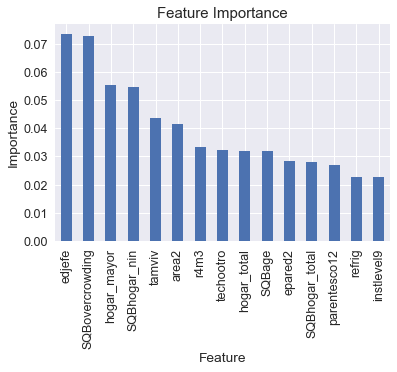

In [38]:
clf = RandomForestClassifier(n_estimators=5000, max_depth=4, class_weight='balanced')
clf.fit(X_train, y_train)
test_predictions = clf.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

x = train.loc[train['parentesco1']==1]
feature_names=list(x)

feature_imp = sorted(list(zip(feature_names, clf.feature_importances_)), key=lambda x: x[1], reverse=True)


feature_importances = feature_imp[0:15]
pd.Series([x[1] for x in feature_importances], index=[x[0] for x in feature_importances]).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

Above I took a simple Random Forest model which worked well before and looked at the feature importance. From this I can see the 15 features that were most influential in the score. However, we do not know the direction that it is influencing the score. For example the SQBOvercrowding was negatively correlated to our Target so it is influential, but if we had it's coefficent value in a linear regression way, it would be negative. 


## Answers

### Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?

In this assignment I used four different models. I used SVC, K-nearest Neighbors, Random Forrest, and Gradient Boosting. I used these models because they are the main classification models we went over in class which work fro multi-class classification problems. Some of these models worked better than others. The SVC model consistently was the worst and tended to run slow as well. This model does not lend itself well to multiclass problems though so it makes sense that it runs a bit worse. Random Forrests and K-NearestNeighbors actually worked quite well for me. The K-NearestNeighbors worked well for me right out of the box while it took me a bit more time hypertuning the parameters for Random Forrest before it worked well for me. This Classification problem is difficult because its three lower income options don't have very many data points in them and it is difficult to tell the difference between varying levels of poverty so some of my models would not predict any to be in one of the poverty classes for some of the loops of the model it would run which would then throw an error when trying to compute the F1_macro score because the averaging process would encounter a division by a negative. There was a razor's edge between getting some of the models to predict to all classes without overfitting my model. For most of my models I chose my hyper-parameters by feeding in a variety of parameters and using the gridsearchCV to run through them and see find the best one. 

## Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?

I looked mostly at f1_macro scores because that was the metric that was used in this competition, but I also printed accuracy as well as precision and recall. It looked like the best f1_macro scores I was getting without overfitting was the mid .3's like .34-.37. I was also looking at accuracy scores in the mid 60's. According to some discusions on the Kaggle page, this dataset is difficult to get good scores on becasue it is really hard for models to differentiate between different levels of poverty. The best scores on kaggle were in the low .4 so I wasn't too close but not too far off either. Once I started to correct for weights in the class I was getting a little bit better scores too. There is a point where my models work well but it is hard to find that point where it goes from underfitting to overfitting. The accuracy metric is not very helpful in this case because the target is not well balanced so a blind model could just always guess that the people are not in poverty and get a decent accuracy score. Recall and percision are both related to the f1 score so f1 is the most holistic score in this case. 

## Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 

These models show me that this is in fact a difficult question to answer. I would say my models had a high tendency to overfit becasue I did not have very much data to work with and quite a few variables. Depending on the sizes that I cut my data into when training my models I was training on anywhere from 1200-3000 data points which it turns out was not always enough to help protect against overtraining. I think it just comes down to the fact that it isn't possible to get an amazing score on this problem. In order to say how confident I am in my model I would need to know how a person would do in rating the data or how well their old models do. It's difficult to know what they would consider would be good or bad. In terms of correctly dividing the data into the right classes, the models don't do great, but they maight be doing really well based on how hard the problem is. The variables that prove to be most important are things like meaneducation of adults in household and education of male head of house as well as overcrowding. All of these features make intuitive sense as well. 

## Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? 

As I was saying above, I don't have a great sense for what is good and bad when it comes to this model. Unlike with the last homework where we know that deviation from true housing price is a good measure for usefulness of a model, we don't have a similar statistic for this problem. Clearly we would want to categorize people into the proper wealth group, but a metric for how close we come to this is not qutie as clear. If we use the kaggle leaderboard as a measure for how well these models preform then I would say our weight corrected random forrest and k-nearest neighbors works quite well. If the government wanted to run a quite model that could roughly categorize people at a low cost, than I believe this model would work well. I think maybe a combination of running one of these models and combining it with another technique for classification may work better. The difficult people to classify for this problem are the people who are really close to being in two classes. When it comes down to it though, there is probably some give either way for these people so while the model might not predict exactly what these people are labeld as, it may be that the model more accuratly labels the people than what there label is. This may not be the case, but this does seem to be a softer problem than the housing price problem we looked at last. 